### РОССИЙСКИЙ УНИВЕРСИТЕТ ДРУЖБЫ НАРОДОВ

#### Факультет физико-математических и естественных наук  
#### Кафедра информационных технологий 

## ОТЧЕТ ПО ЛАБОРАТОРНОЙ РАБОТЕ № 5


### Дисциплина: Методы машинного обучения

##### Студент:  Яссин Мохамад Аламин
##### Группа:   НКНбд-01-20

## Москва 2023
***

# Вариант №17
Лабораторная работа 5


## Текст задания:

1. Считайте котировки акции с указанным ниже тикером за 2020-2021 год: 

 TSM    Taiwan Semiconductor Manufacturing ADR 

2. Показатель акции: дневная доходность, способ визуализации – эмпирическая PDF

3. Прогнозирование стоимости акции через 5 дней по данным за предыдущие 20 дней. 

4. Показатель качества MSE 

5. Техника борьбы с исчезающими градиентами: 

    Альтернативная инициализация весов 


## Решение:

In [ ]:
from pandas_datareader import data as pdr
import yfinance as yfin
import datetime as dt
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import numpy as np
from sklearn.metrics import mean_squared_error


### 1. При помощи модуля `pandas_datareader` считайте котировки указанной в индивидуальным задании акции за указанный период времени. 

In [ ]:
yfin.pdr_override()

TSM = pdr.get_data_yahoo('TSM', 
                          start=dt.datetime(2020, 1, 1), 
                          end=dt.datetime(2021, 12, 31))
TSM.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,59.599998,60.119999,59.599998,60.040001,56.058460,8432600
2020-01-03,58.970001,58.980000,58.040001,58.060001,54.209763,10546400
2020-01-06,57.599998,57.689999,57.130001,57.389999,53.584190,8897200
2020-01-07,57.450001,58.599998,56.740002,58.320000,54.452518,7444300
2020-01-08,58.189999,58.980000,58.110001,58.750000,54.854004,5381500


### 2. Визуализируйте котировки акции (столбец `Adj Close`) за весь период на графике. Подпишите оси и рисунок.


Text(0, 0.5, 'Values')

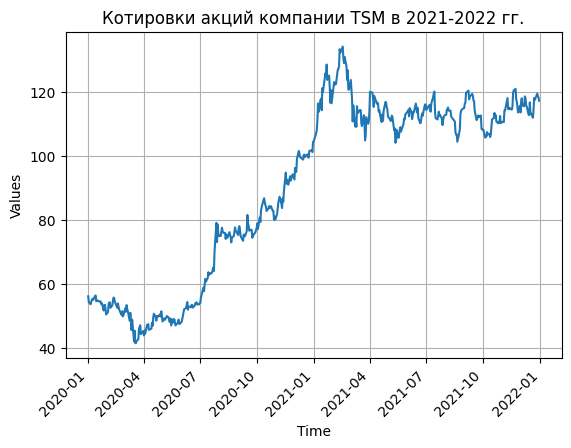

In [ ]:
fig, ax = plt.subplots()
ax.plot(TSM['Adj Close'])
ax.grid(True)
ax.set_title("Котировки акций компании TSM в 2021-2022 гг.")
ax.set_xlabel('Time')
fig.autofmt_xdate(rotation=45)
ax.set_ylabel('Values')

#TSM['Close'].plot.line(grid=True,title='Котировки акций компании Apple в 2016-2022 гг.');

### 3. Вычислите и визуализируйте заданный показатель акции в соответствии с индивидуальным заданием.
дневная доходность, способ визуализации – эмпирическая PDF



In [ ]:
d_close = TSM[['Adj Close']]
d_pct_ch2 = d_close / d_close.shift(1) - 1
d_pct_ch2 = d_pct_ch2.dropna()
d_pct_ch2

,Adj Close
Date,
2020-01-03,-0.032978
2020-01-06,-0.011540
2020-01-07,0.016205
2020-01-08,0.007373
2020-01-09,0.008170
...,...
2021-12-23,-0.005111
2021-12-27,0.016738
2021-12-28,-0.005216


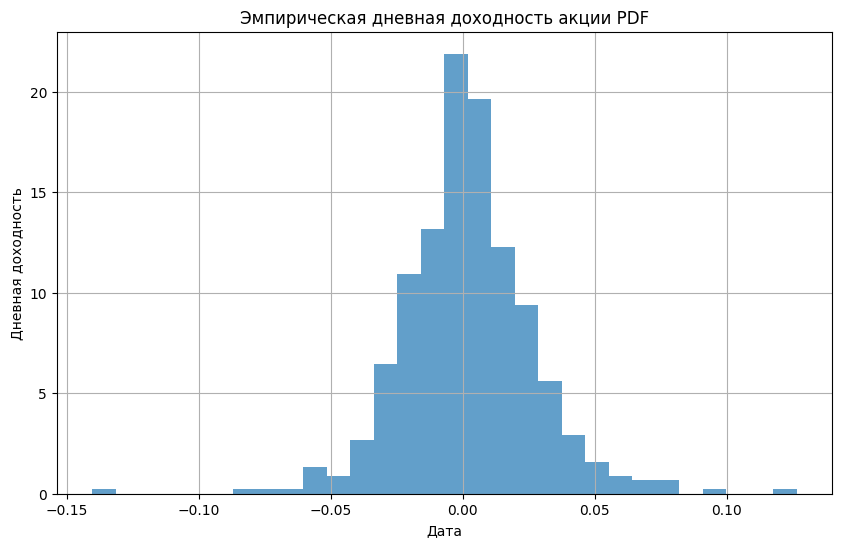

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(d_pct_ch2['Adj Close'], bins=30, density=True, alpha=0.7)
plt.xlabel('Дата')
plt.ylabel('Дневная доходность')
plt.title('Эмпирическая дневная доходность акции PDF')
plt.grid(True)
plt.show()

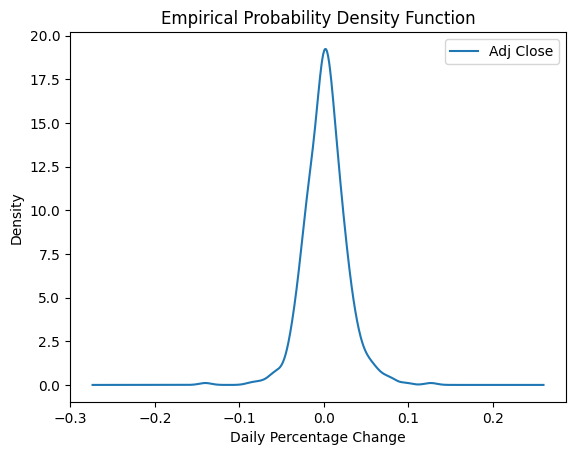

In [ ]:
pdf = d_pct_ch2.plot(kind='density')

# Настройка заголовка и осей
plt.title('Empirical Probability Density Function')
plt.xlabel('Daily Percentage Change')
plt.ylabel('Density')

plt.show()


### 4. Сформируйте обучающую, тестовую и валидационные выборки для обучения нейронной сети в соответствии с индивидуальным заданием. 


In [ ]:
# Define parameters
sampling_rate = 1
sequence_length = 20
delay= 5
batch_size = 32

# Convert data to numpy arrays
raw_data = TSM['Adj Close'].values
targets = raw_data[delay:]

num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples


mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std # whole raw_data normalized w.r.t. first num_train_samples rows


raw_data=raw_data.reshape(-1, 1)
# Create training dataset
train_dataset = tf.keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=targets,
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples
)

# Create validation dataset
val_dataset = tf.keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=targets,
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples
)

# Create testing dataset
test_dataset = tf.keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=targets,
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples
)


### 5. Постройте нейронную сеть MLP с нормализующим слоем и одним плотным скрытым слоем из 16 нейронов для прогнозирования стоимости акции и обучите ее на обучающей выборке. Оцените качество прогнозирования при помощи заданного показателя качества на тестовой выборке.


In [ ]:
inputs = tf.keras.Input(shape=(sequence_length, 1))
x = tf.keras.layers.Flatten()(inputs)
x = tf.keras.layers.BatchNormalization()(x)  
x = tf.keras.layers.Dense(16, activation="relu")(x)
outputs = tf.keras.layers.Dense(1)(x)
model1 = tf.keras.Model(inputs, outputs)

model1.compile(optimizer="rmsprop", loss="mse")
history1 = model1.fit(train_dataset, epochs=50, validation_data=val_dataset)

Epoch 1/50
8/8 [==============================] - 3s 159ms/step - loss: 0.4948 - val_loss: 2.6051
Epoch 2/50
8/8 [==============================] - 1s 38ms/step - loss: 0.1156 - val_loss: 0.4513
Epoch 3/50
8/8 [==============================] - 1s 50ms/step - loss: 0.1069 - val_loss: 0.3307
Epoch 4/50
8/8 [==============================] - 0s 34ms/step - loss: 0.0918 - val_loss: 0.9439
Epoch 5/50
8/8 [==============================] - 0s 26ms/step - loss: 0.0606 - val_loss: 0.5116
Epoch 6/50
8/8 [==============================] - 0s 22ms/step - loss: 0.0979 - val_loss: 0.4978
Epoch 7/50
8/8 [==============================] - 0s 27ms/step - loss: 0.0768 - val_loss: 0.3120
Epoch 8/50
8/8 [==============================] - 0s 32ms/step - loss: 0.0644 - val_loss: 0.6877
Epoch 9/50
8/8 [==============================] - 0s 34ms/step - loss: 0.0700 - val_loss: 0.6957
Epoch 10/50
8/8 [==============================] - 0s 26ms/step - loss: 0.0977 - val_loss: 1.5502
Epoch 11/50
8/8 [===========

In [ ]:
mse = model1.evaluate(test_dataset)
print("Mean Squared Error (MSE):", mse)

4/4 [==============================] - 0s 4ms/step - loss: 0.0603
Mean Squared Error (MSE): 0.060337189584970474


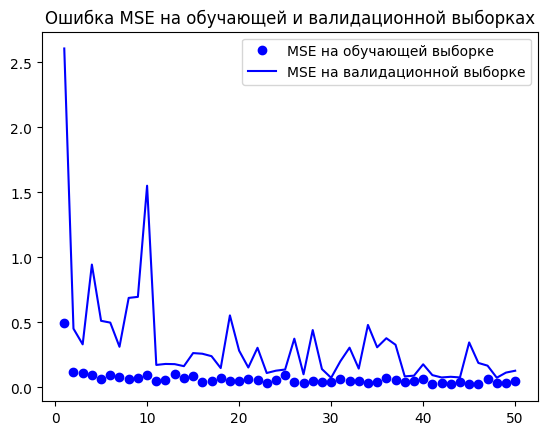

In [ ]:
loss = history1.history["loss"]
val_loss = history1.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="MSE на обучающей выборке")
plt.plot(epochs, val_loss, "b", label="MSE на валидационной выборке")
plt.title("Ошибка MSE на обучающей и валидационной выборках")
plt.legend();

### 6. Примените указанную в индивидуальном задании технику решения проблемы исчезающих градиентов и постройте нейронную сеть MLP с нормализующим слоем и тремя плотными скрытыми слоями из 16 нейронов для прогнозирования стоимости акции и обучите ее на обучающей выборке. Оцените качество прогнозирования при помощи заданного показателя качества для тестовой выборки.



In [ ]:
inputs = tf.keras.Input(shape=(sequence_length, 1))
x = tf.keras.layers.Flatten()(inputs)
x = tf.keras.layers.BatchNormalization()(x)  
x = tf.keras.layers.Dense(16, activation="relu",kernel_initializer="he_normal")(x)
x = tf.keras.layers.Dense(16, activation="relu",kernel_initializer="he_normal")(x)
x = tf.keras.layers.Dense(16, activation="relu",kernel_initializer="he_normal")(x)
outputs = tf.keras.layers.Dense(1)(x)
model2 = tf.keras.Model(inputs, outputs)

model2.compile(optimizer="rmsprop", loss="mse")
history2 = model2.fit(train_dataset, epochs=50, validation_data=val_dataset)

Epoch 1/50
8/8 [==============================] - 1s 31ms/step - loss: 0.9464 - val_loss: 4.0637
Epoch 2/50
8/8 [==============================] - 0s 24ms/step - loss: 0.3837 - val_loss: 2.1193
Epoch 3/50
8/8 [==============================] - 0s 12ms/step - loss: 0.2150 - val_loss: 1.3051
Epoch 4/50
8/8 [==============================] - 0s 12ms/step - loss: 0.1080 - val_loss: 0.6240
Epoch 5/50
8/8 [==============================] - 0s 10ms/step - loss: 0.0566 - val_loss: 0.0290
Epoch 6/50
8/8 [==============================] - 0s 12ms/step - loss: 0.0782 - val_loss: 0.6472
Epoch 7/50
8/8 [==============================] - 0s 15ms/step - loss: 0.0527 - val_loss: 0.2542
Epoch 8/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0475 - val_loss: 0.1439
Epoch 9/50
8/8 [==============================] - 0s 12ms/step - loss: 0.0517 - val_loss: 0.2925
Epoch 10/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0554 - val_loss: 0.1930
Epoch 11/50
8/8 [============

In [ ]:
mse = model2.evaluate(test_dataset)
print("Mean Squared Error (MSE):", mse)

4/4 [==============================] - 0s 3ms/step - loss: 0.2653
Mean Squared Error (MSE): 0.2653135657310486


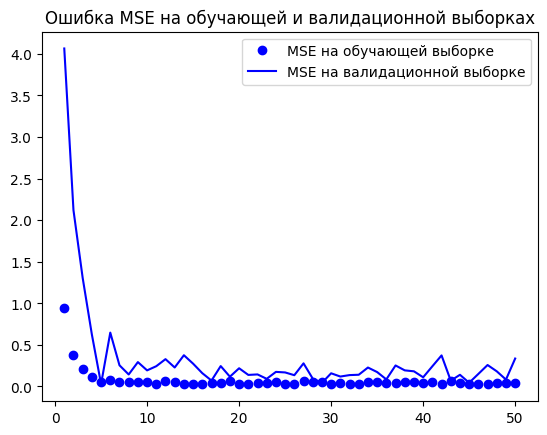

In [ ]:
loss = history2.history["loss"]
val_loss = history2.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="MSE на обучающей выборке")
plt.plot(epochs, val_loss, "b", label="MSE на валидационной выборке")
plt.title("Ошибка MSE на обучающей и валидационной выборках")
plt.legend();

### 7. Постройте рекуррентную нейронную сеть с нормализующим слоем и одним скрытым слоем LSTM из 16 нейронов для прогнозирования стоимости акции и обучите ее на обучающей выборке. Оцените качество прогнозирования при помощи заданного показателя качества на тестовой выборке.



In [ ]:
inputs = tf.keras.Input(shape=(sequence_length, 1))
x = tf.keras.layers.Flatten()(inputs)
x = tf.keras.layers.BatchNormalization()(x)  
x = tf.keras.layers.LSTM(16)(inputs) 
outputs = tf.keras.layers.Dense(1)(x)
model3 = tf.keras.Model(inputs, outputs)

model3.compile(optimizer="rmsprop", loss="mse")
history3 = model3.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                   ) 

Epoch 1/50
8/8 [==============================] - 3s 94ms/step - loss: 0.6360 - val_loss: 6.9986
Epoch 2/50
8/8 [==============================] - 0s 18ms/step - loss: 0.3819 - val_loss: 6.3044
Epoch 3/50
8/8 [==============================] - 0s 31ms/step - loss: 0.2438 - val_loss: 5.6200
Epoch 4/50
8/8 [==============================] - 0s 31ms/step - loss: 0.1583 - val_loss: 5.0833
Epoch 5/50
8/8 [==============================] - 0s 21ms/step - loss: 0.1129 - val_loss: 4.6265
Epoch 6/50
8/8 [==============================] - 0s 20ms/step - loss: 0.0870 - val_loss: 4.1902
Epoch 7/50
8/8 [==============================] - 0s 20ms/step - loss: 0.0719 - val_loss: 3.7782
Epoch 8/50
8/8 [==============================] - 0s 20ms/step - loss: 0.0614 - val_loss: 3.5369
Epoch 9/50
8/8 [==============================] - 0s 20ms/step - loss: 0.0529 - val_loss: 3.1816
Epoch 10/50
8/8 [==============================] - 0s 30ms/step - loss: 0.0441 - val_loss: 2.9059
Epoch 11/50
8/8 [============

In [ ]:
mse = model3.evaluate(test_dataset)
print("Mean Squared Error (MSE):", mse)

4/4 [==============================] - 0s 7ms/step - loss: 0.6924
Mean Squared Error (MSE): 0.692421555519104


### 8. Визуализируйте кривые обучения для трех построенных моделей на одном рисунке в зависимости от эпохи обучения, подписывая оси и рисунок и создавая легенду. Используйте для визуализации относительную ошибку (ошибку обучения, деленную на начальную ошибку на первой эпохе). 



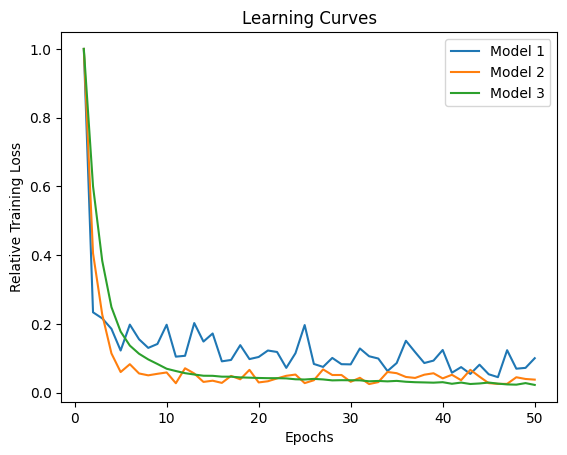

In [ ]:
import matplotlib.pyplot as plt

# Extract the training loss history for each model
model_1_train_loss = history1.history['loss']
model_2_train_loss = history2.history['loss']
model_3_train_loss = history3.history['loss']

# Calculate the relative training loss for each model
model_1_relative_loss = [loss / model_1_train_loss[0] for loss in model_1_train_loss]
model_2_relative_loss = [loss / model_2_train_loss[0] for loss in model_2_train_loss]
model_3_relative_loss = [loss / model_3_train_loss[0] for loss in model_3_train_loss]

# Plot the learning curves
epochs = range(1, len(model_1_train_loss) + 1)
plt.plot(epochs, model_1_relative_loss, label='Model 1')
plt.plot(epochs, model_2_relative_loss, label='Model 2')
plt.plot(epochs, model_3_relative_loss, label='Model 3')

# Set plot labels and legend
plt.xlabel('Epochs')
plt.ylabel('Relative Training Loss')
plt.title('Learning Curves')
plt.legend()

# Show the plot
plt.show()

### 9. Визуализируйте весь набор данных и прогнозы трех построенных моделей для обучающей и тестовой выборок на одном рисунке (ось X – даты, ось Y – стоимость акции), подписывая оси и рисунок и создавая легенду. 



8/8 [==============================] - 0s 3ms/step


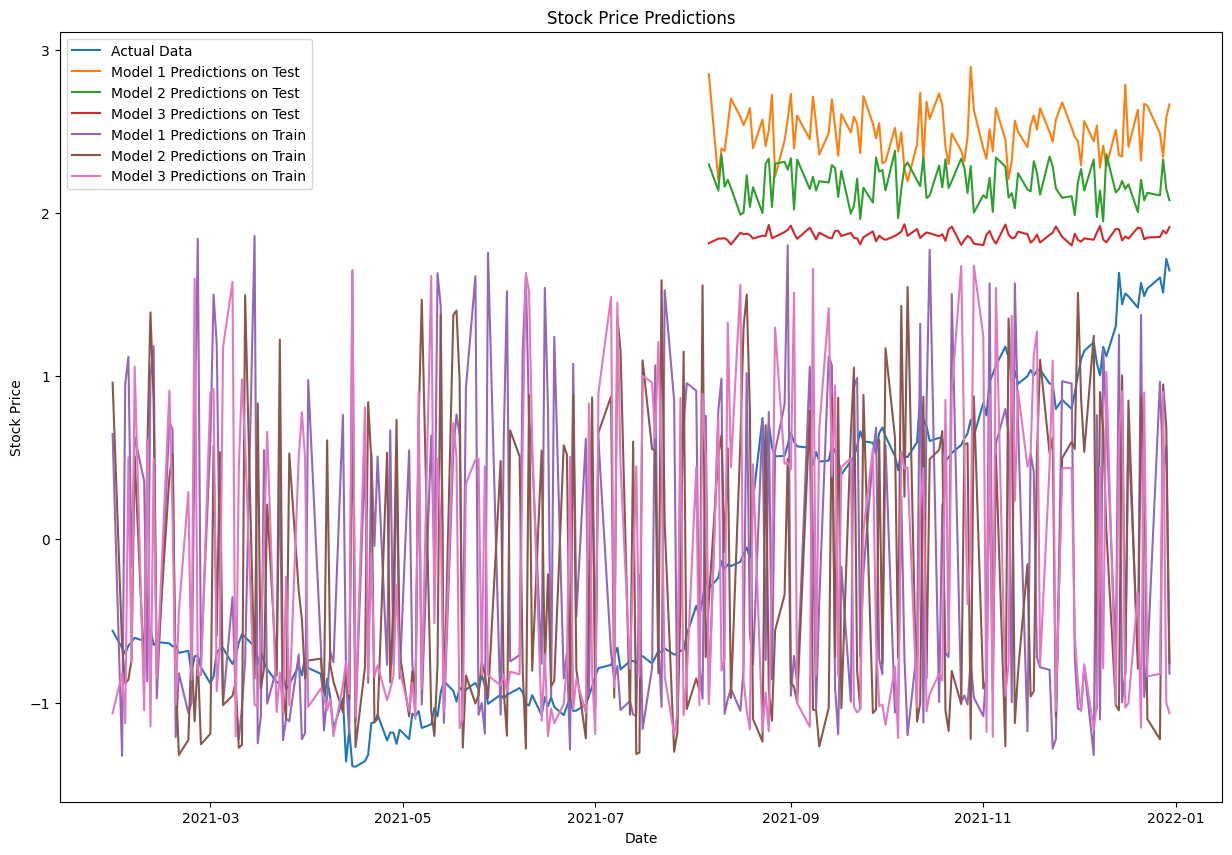

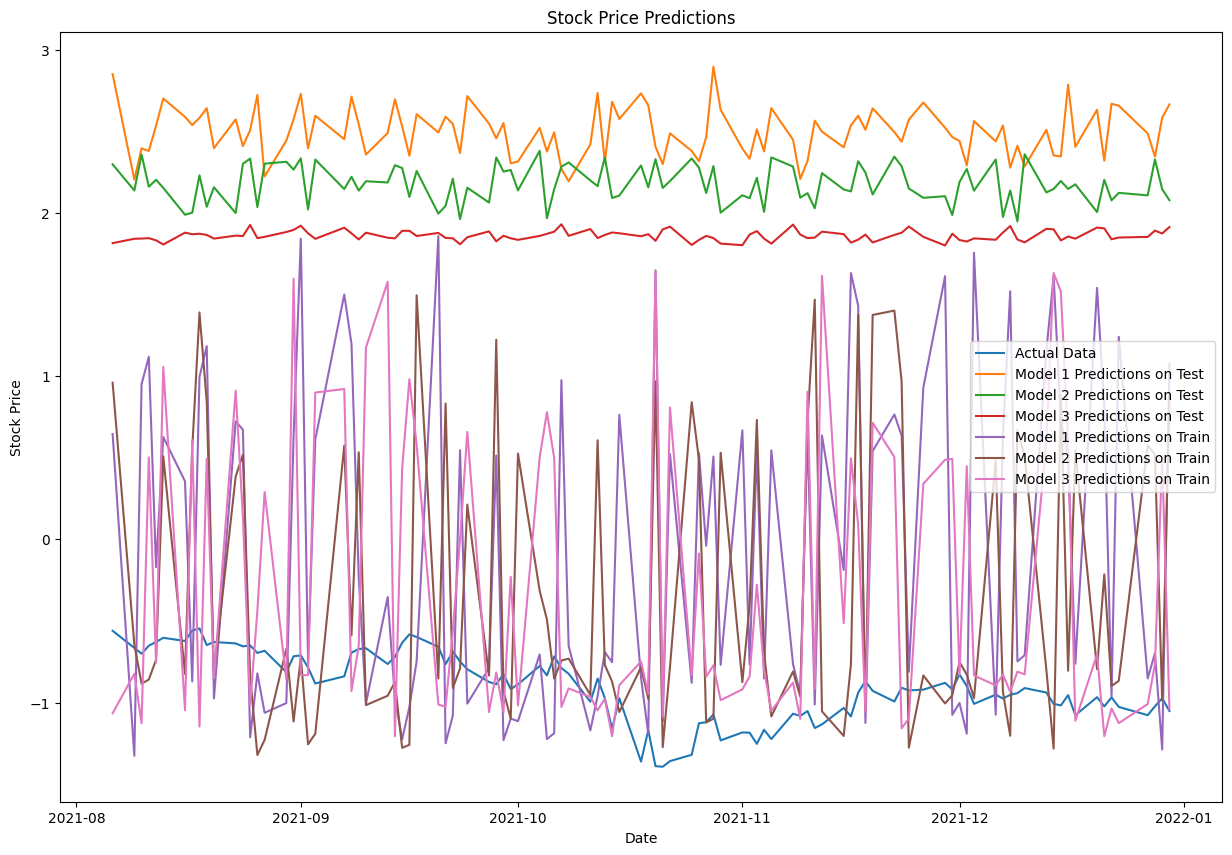

In [ ]:
# Get the original data
dates = TSM.index
actual_data = TSM['Adj Close']

# Get the predictions for each model on the test set
model_1_predictions_test = model1.predict(test_dataset).reshape(-1)
model_2_predictions_test = model2.predict(test_dataset).reshape(-1)
model_3_predictions_test = model3.predict(test_dataset).reshape(-1)

# Get the predictions for each model on the training set
model_1_predictions_train = model1.predict(train_dataset).reshape(-1)
model_2_predictions_train = model2.predict(train_dataset).reshape(-1)
model_3_predictions_train = model3.predict(train_dataset).reshape(-1)

# Create a new figure
plt.figure(figsize=(15, 10))

# Plot the entire dataset
plt.plot(dates[-len(model_1_predictions_train):], actual_data[:len(model_1_predictions_train)], label='Actual Data')

# Plot the predictions for each model on the test set
plt.plot(dates[-len(model_1_predictions_test):], model_1_predictions_test, label='Model 1 Predictions on Test')
plt.plot(dates[-len(model_2_predictions_test):], model_2_predictions_test, label='Model 2 Predictions on Test')
plt.plot(dates[-len(model_3_predictions_test):], model_3_predictions_test, label='Model 3 Predictions on Test')

# Plot the predictions for each model on the training set
plt.plot(dates[-len(model_1_predictions_train):], model_1_predictions_train, label='Model 1 Predictions on Train')
plt.plot(dates[-len(model_2_predictions_train):], model_2_predictions_train, label='Model 2 Predictions on Train')
plt.plot(dates[-len(model_3_predictions_train):], model_3_predictions_train, label='Model 3 Predictions on Train')

# Set plot labels and legend
plt.title('Stock Price Predictions')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()

# Show the plot
plt.show()

# Create a new figure
plt.figure(figsize=(15, 10))

#printing the last section of the dataset
plt.plot(dates[-len(model_1_predictions_test):], actual_data[:len(model_1_predictions_test)], label='Actual Data')
plt.plot(dates[-len(model_1_predictions_test):], model_1_predictions_test, label='Model 1 Predictions on Test')
plt.plot(dates[-len(model_2_predictions_test):], model_2_predictions_test, label='Model 2 Predictions on Test')
plt.plot(dates[-len(model_3_predictions_test):], model_3_predictions_test, label='Model 3 Predictions on Test')
plt.plot(dates[-len(model_1_predictions_test):], model_1_predictions_train[:len(model_1_predictions_test)], label='Model 1 Predictions on Train')
plt.plot(dates[-len(model_1_predictions_test):], model_2_predictions_train[:len(model_1_predictions_test)], label='Model 2 Predictions on Train')
plt.plot(dates[-len(model_1_predictions_test):], model_3_predictions_train[:len(model_1_predictions_test)], label='Model 3 Predictions on Train')

# Set plot labels and legend
plt.title('Stock Price Predictions')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()

# Show the plot
plt.show()
